# Data Preprocessing and EDA

##    Libraries Import

In [1]:
import os

import warnings

import numpy as np
import pandas as pd
from category_encoders import (
    BackwardDifferenceEncoder,
    BaseNEncoder,
    BinaryEncoder,
    CatBoostEncoder,
    CountEncoder,
    GLMMEncoder,
    HelmertEncoder,
    JamesSteinEncoder,
    LeaveOneOutEncoder,
    MEstimateEncoder,
    SummaryEncoder,
    TargetEncoder,
    WOEEncoder,
)
from sklearn import set_config
from sklearn.base import clone as model_clone
from sklearn.cluster import *
from sklearn.compose import *
from sklearn.cross_decomposition import *
from sklearn.decomposition import *
from sklearn.ensemble import *
from sklearn.feature_selection import *
from sklearn.gaussian_process import *
from sklearn.linear_model import *
from sklearn.metrics import *
from sklearn.model_selection import *
from sklearn.multioutput import *
from sklearn.multiclass import *
from sklearn.naive_bayes import *
from sklearn.neighbors import *
from sklearn.neural_network import *
from sklearn.pipeline import *
from sklearn.preprocessing import *
from sklearn.svm import *
from sklearn.tree import *
from sklearn.utils import *
from sklearn.dummy import *
from sklearn.semi_supervised import *
from sklearn.discriminant_analysis import *

from xgboost import XGBClassifier, XGBRFClassifier

from sklearn.calibration import *
import joblib
pd.options.display.max_columns = 50
set_config(display="diagram")
warnings.filterwarnings("ignore")
import pickle
from collections import defaultdict
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
from joblib import parallel_backend
from joblib.memory import Memory
def allow_stopping(func):
    def wrapper():
        try:
            value = func()
            return value
            # gc.collect()
        except KeyboardInterrupt as e:
            print("Program Stopped")
        gc.collect()

    return wrapper

__refresh__ = 0

def run_if_refresh(func):
    def wrapper():
        global __refresh__
        if __refresh__ == 1:
            value = func()
            return value
        else:
            print("Using Cache, Set Refresh to '__refresh__=1' to regenerate " \
                  "the output of this  function")
    return wrapper


###    ColumnSelectors

In [2]:
class ColumnSelectors:
    def __init__(self, default=None):
        self.dtype_info = {
            "binary__v_1": "Binary",
            "binary__v_11": "Binary",
            "binary__v_14": "Binary",
            "binary__v_26": "Binary",
            "binary__v_27": "Binary",
            "binary__v_28": "Binary",
            "binary__v_30": "Binary",
            "binary__v_9": "Binary",
            "nominal__v_12": "Nominal",
            "nominal__v_18": "Nominal",
            "nominal__v_20": "Nominal",
            "nominal__v_21": "Nominal",
            "nominal__v_25": "Nominal",
            "nominal__v_3": "Nominal",
            "nominal__v_32": "Nominal",
            "nominal__v_4": "Nominal",
            "ordinal__v_0": "Ordinal",
            "ordinal__v_10": "Ordinal",
            "ordinal__v_13": "Ordinal",
            "ordinal__v_15": "Ordinal",
            "ordinal__v_17": "Ordinal",
            "ordinal__v_19": "Ordinal",
            "ordinal__v_22": "Ordinal",
            "ordinal__v_23": "Ordinal",
            "ordinal__v_24": "Ordinal",
            "ordinal__v_29": "Ordinal",
            "ordinal__v_31": "Ordinal",
            "ordinal__v_33": "Ordinal",
            "ordinal__v_5": "Ordinal",
            "ordinal__v_6": "Ordinal",
            "ratio__v_16": "Ratio",
            "ratio__v_2": "Ratio",
            "ratio__v_34": "Ratio",
            "ratio__v_35": "Ratio",
            "ratio__v_36": "Ratio",
            "ratio__v_37": "Ratio",
            "ratio__v_38": "Ratio",
            "ratio__v_39": "Ratio",
            "ratio__v_40": "Ratio",
            "ratio__v_7": "Ratio",
            "ratio__v_8": "Ratio",
        }

        self.ordinal_cols = [
            i for i in self.dtype_info if self.dtype_info[i] == "Ordinal"
        ]
        self.nominal_cols = [
            i for i in self.dtype_info if self.dtype_info[i] == "Nominal"
        ]
        self.binary_cols = [
            i for i in self.dtype_info if self.dtype_info[i] == "Binary"
        ]
        self.ratio_cols = [i for i in self.dtype_info if self.dtype_info[i] == "Ratio"]
        self.ordinal = make_column_selector(
            pattern="|".join(self.ordinal_cols),
        )
        self.nominal = make_column_selector(
            pattern="|".join(self.nominal_cols),
        )
        self.binary = make_column_selector(
            pattern="|".join(self.binary_cols),
        )
        self.ratio = make_column_selector(
            pattern="|".join(self.ratio_cols),
        )

    def ordinal_selector(self):
        return self.ordinal

    def nominal_selector(self):
        return self.nominal

    def binary_selector(self):
        return self.binary

    def ratio_selector(self):
        return self.ratio
    
    def categorise_data(self, df: pd.DataFrame = None):
        """
        Categorise Data based on given data
        :params df : pandas.Dataframe
        """
        if isinstance(df, pd.DataFrame):
            ordinal_data = df.loc[:, self.ordinal_cols]
            nominal_data = df.loc[:, self.nominal_cols]
            binary_data = df.loc[:, self.binary_cols]
            ratio_data = df.loc[:, self.ratio_cols]
        else:
            print("Please provide valid Data")
        return ordinal_data, nominal_data, binary_data, ratio_data

column_directory = ColumnSelectors()

## Prepare Data and Execution Enviroment

### Rename Columns and Start Data Save

In [3]:
DATA_PATH="/kaggle/input/students-drop-out-prediction/"
DATA_SAVE_PATH='/kaggle/working/'
TRAIN_DATA='train.csv'
TEST_DATA='test.csv'
KAGGLE_ENV =1

cwd = os.path.abspath(os.getcwd())
if 'mlop3n/Pycharm' in cwd:
    KAGGLE_ENV = 0

if KAGGLE_ENV == 0:
    LOCAL_PATH = '../data'
    DATA_PATH = LOCAL_PATH + DATA_PATH
    DATA_SAVE_PATH= LOCAL_PATH + DATA_SAVE_PATH
    
#TODO rerun this script to rename the target column

@run_if_refresh
def rename_columns_with_dtype(DATA_PATH=DATA_PATH,DATA_SAVE_PATH=DATA_SAVE_PATH):
    raw_data = pd.read_csv(DATA_PATH+TRAIN_DATA,index_col=0)
    raw_data_eval = pd.read_csv(DATA_PATH+TEST_DATA,index_col=0)

    raw_dtypes_info = {}
    saved_dtypes_info = column_directory.dtype_info
    for k, v in saved_dtypes_info.items():
        tmp = k.split('__')
        data_type = tmp[0]
        column_name = tmp[1]
        raw_dtypes_info[column_name] = k

    raw_data.rename(columns=raw_dtypes_info,inplace=True)
    raw_data_eval.rename(columns=raw_dtypes_info,inplace=True)
    raw_data.rename(columns={'label': 'target'},inplace=True)
    raw_data.to_parquet(DATA_SAVE_PATH+'train.parquet')
    raw_data_eval.to_parquet(DATA_SAVE_PATH+'test.parquet')

rename_columns_with_dtype()

Using Cache, Set Refresh to '__refresh__=1' to regenerate the output of this  function


### Load Renamed Data

In [4]:
raw_data = pd.read_parquet(DATA_SAVE_PATH + 'train.parquet')
raw_data_eval = pd.read_parquet(DATA_SAVE_PATH + 'test.parquet')

### Load Metadata

In [128]:
ordinal = column_directory.ordinal_cols
nominal = column_directory.nominal_cols
binary = column_directory.binary_cols
ratios = column_directory.ratio_cols

ordinal_data, nominal_data, binary_data, ratios_data = column_directory.categorise_data(raw_data)
ordinal_data_eval, nominal_data_eval, binary_data_eval, ratios_data_eval = column_directory.categorise_data(raw_data_eval)

### Delete Unwanted Categories

#### Unique Categories within each feature

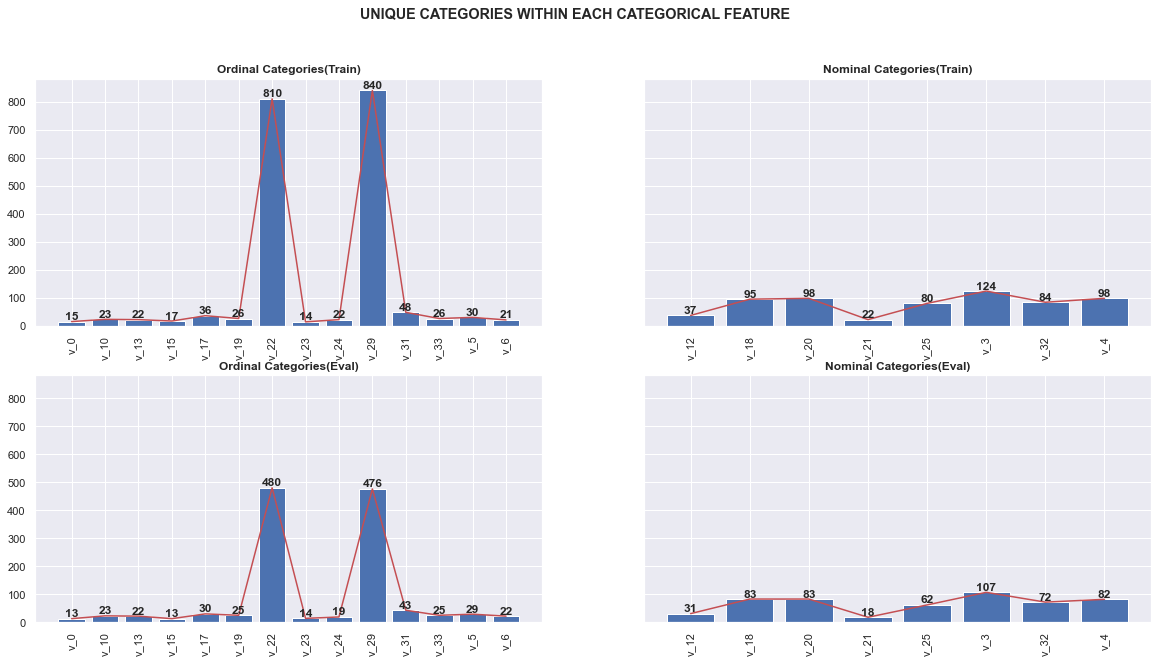

In [7]:
"""
Unique Categories within each categorical feature.
"""
fig, ax = plt.subplots(2,2,figsize=(20,10),squeeze=False, sharey=True)
data_to_plot = [ordinal_data,nominal_data,ordinal_data_eval,nominal_data_eval]
fig.suptitle('Unique Categories within each categorical feature'.upper(), fontweight='bold')
data_titles = [
    "Ordinal Categories(Train)",
    "Nominal Categories(Train)",
    "Ordinal Categories(Eval)",
    "Nominal Categories(Eval)",
]
idx = 0
for i in range(2):
    for j in range(2):  
        ax_ = ax[i,j]
        data = data_to_plot[idx]
        
        values = data.nunique().values
        Xlabels = [x.split('__')[1] for x in data.nunique().index]
        disp = ax_.bar(x=Xlabels, height=values)
        disp1 = ax_.set_title(data_titles[idx], fontweight='bold')
        disp2 = ax_.set_xticklabels(Xlabels,rotation=90)
        ax_.bar_label(container=disp,fontweight='bold')
        ax_.plot(values,'-r')
        idx+=1

##### Nominal Categories to Delete

In [129]:
"""
Nominal Categories to delete = Unique_Categories (Union - Intersection)
"""
def find_nominal_uncommon_categories(nominal_data=nominal_data, nominal_data_eval=nominal_data_eval):
    missing_categories_dict = {}
    for c in nominal:
        nominal_data[c]: pd.Series
        unique_categories_train = set(nominal_data[c].unique())
        # print(unique_categories_test)
        unique_categories_eval = set(nominal_data_eval[c].unique())
        all_categories = unique_categories_train.union(unique_categories_eval)
        common_categories = unique_categories_train.intersection(unique_categories_eval)
        missing_categories = all_categories - common_categories
        missing_categories_dict[c] = list(missing_categories)
    return missing_categories_dict
missing_categories_dict = find_nominal_uncommon_categories()

def classify_uncommon_categories_zero(row):
    for c in nominal:
        if row[c] in missing_categories_dict[c]:
            row[c] = 0
    return row

nominal_data_t = nominal_data.copy() 
nominal_data_t = nominal_data_t.apply(classify_uncommon_categories_zero,axis=1)

nominal_data_eval_t = nominal_data_eval.copy() 
nominal_data_eval_t = nominal_data_eval.apply(classify_uncommon_categories_zero,axis=1)



In [130]:
total_ambiguos_labels_master = {k:0 for k in nominal}
total_ambiguos_labels_train  = {k:0 for k in nominal}
total_ambiguos_labels_eval   = {k:0 for k in nominal}

for k,v in missing_categories_dict.items():
    value_counts_train = nominal_data[k].value_counts().to_dict()
    value_counts_eval = nominal_data_eval[k].value_counts().to_dict()
    # print(value_counts_train)
    for val in v:
        if val in value_counts_train:
            # if k in total_ambiguos_labels_train:
            total_ambiguos_labels_train[k] += value_counts_train[val]
            total_ambiguos_labels_master[k] += value_counts_train[val]
        if val in value_counts_eval:
            total_ambiguos_labels_eval[k] += value_counts_eval[val]
            total_ambiguos_labels_master[k] += value_counts_eval[val]

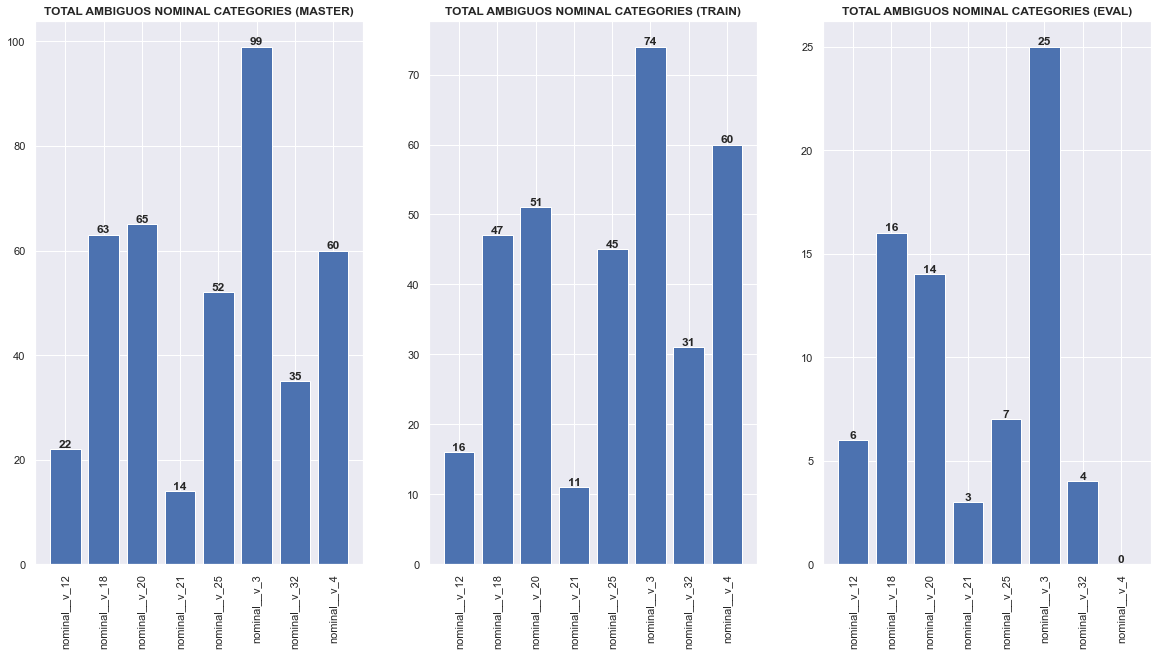

In [131]:
data_to_plot = [
    total_ambiguos_labels_master,
    total_ambiguos_labels_train,
    total_ambiguos_labels_eval
]
data_titles = [
    "Total Ambiguos Nominal Categories (Master)",
    "Total Ambiguos Nominal Categories (Train)",
    "Total Ambiguos Nominal Categories (Eval)",
]
fig, ax = plt.subplots(1,3,squeeze=False,figsize=(20,10))

for idx in range(3):
    # ax_ = ax[idx]
    data = data_to_plot[idx]
    disp = ax[0,idx].bar(data.keys(), height=data.values())
    disp1 = ax[0,idx].set_xticklabels(data.keys(), rotation=90)
    disp = ax[0,idx].bar_label(container=disp,fontweight='bold')
    disp2 = ax[0,idx].set_title(data_titles[idx].upper(), fontweight='bold')
    

##### Ordinal Categories to delete

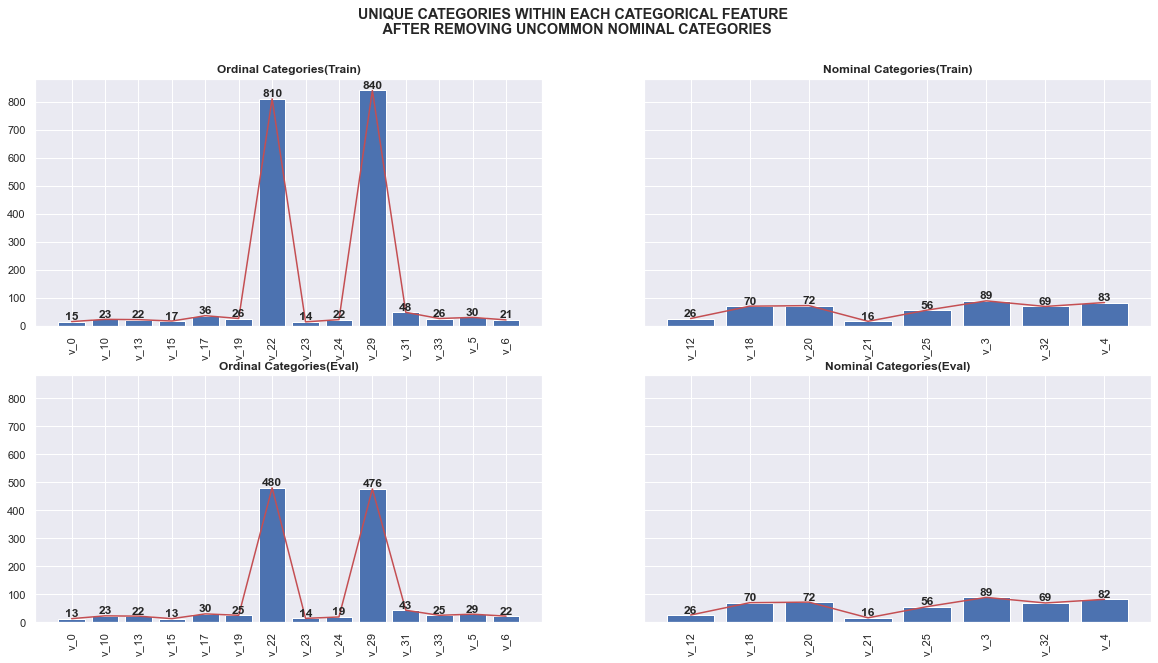

In [127]:
"""
Unique Categories within each categorical feature.
"""
fig, ax = plt.subplots(2,2,figsize=(20,10),squeeze=False, sharey=True)
data_to_plot = [ordinal_data,nominal_data_t,ordinal_data_eval,nominal_data_eval_t]
fig.suptitle('Unique Categories within each categorical feature \n After removing uncommon nominal categories'.upper(), fontweight='bold')
data_titles = [
    "Ordinal Categories(Train)",
    "Nominal Categories(Train)",
    "Ordinal Categories(Eval)",
    "Nominal Categories(Eval)",
]
idx = 0
for i in range(2):
    for j in range(2):  
        ax_ = ax[i,j]
        data = data_to_plot[idx]
        
        values = data.nunique().values
        Xlabels = [x.split('__')[1] for x in data.nunique().index]
        disp = ax_.bar(x=Xlabels, height=values)
        disp1 = ax_.set_title(data_titles[idx], fontweight='bold')
        disp2 = ax_.set_xticklabels(Xlabels,rotation=90)
        ax_.bar_label(container=disp,fontweight='bold')
        ax_.plot(values,'-r')
        idx+=1

In [122]:
"""
Ordinal Categories to delete = Unique_Categories (Union - Intersection)
"""
def find_ordinal_uncommon_categories(ordinal_data=ordinal_data, ordinal_data_eval=ordinal_data_eval):
    missing_categories_dict = {}
    for c in ordinal:
        nominal_data[c]: pd.Series
        unique_categories_train = set(ordinal_data[c].unique())
        # print(unique_categories_test)
        unique_categories_eval = set(ordinal_data_eval[c].unique())
        all_categories = unique_categories_train.union(unique_categories_eval)
        common_categories = unique_categories_train.intersection(unique_categories_eval)
        missing_categories = all_categories - common_categories
        missing_categories_dict[c] = list(missing_categories)
    return missing_categories_dict


missing_categories_dict = find_ordinal_uncommon_categories()
missing_categories_count_ordinal = {k:len(v) for k,v in missing_categories_dict.items()}

# fig, ax = plt.subplots(1,1)
# disp = ax.bar(missing_categories_count_nominal.keys(), height=missing_categories_count_nominal.values())
# disp1 = ax.set_xticklabels(missing_categories_count_nominal.keys(), rotation=90)
# # ax[0].bar_label(container=disp,fontweight='bold')
# disp = ax.bar_label(container=disp,fontweight='bold')


In [123]:
total_ambiguos_labels_master = {k:0 for k in ordinal}
total_ambiguos_labels_train  = {k:0 for k in ordinal}
total_ambiguos_labels_eval   = {k:0 for k in ordinal}

for k,v in missing_categories_dict.items():
    value_counts_train = ordinal_data[k].value_counts().to_dict()
    value_counts_eval = ordinal_data_eval[k].value_counts().to_dict()
    # print(value_counts_train)
    for val in v:
        if val in value_counts_train:
            # if k in total_ambiguos_labels_train:
            total_ambiguos_labels_train[k] += value_counts_train[val]
            total_ambiguos_labels_master[k] += value_counts_train[val]
        if val in value_counts_eval:
            total_ambiguos_labels_eval[k] += value_counts_eval[val]
            total_ambiguos_labels_master[k] += value_counts_eval[val]

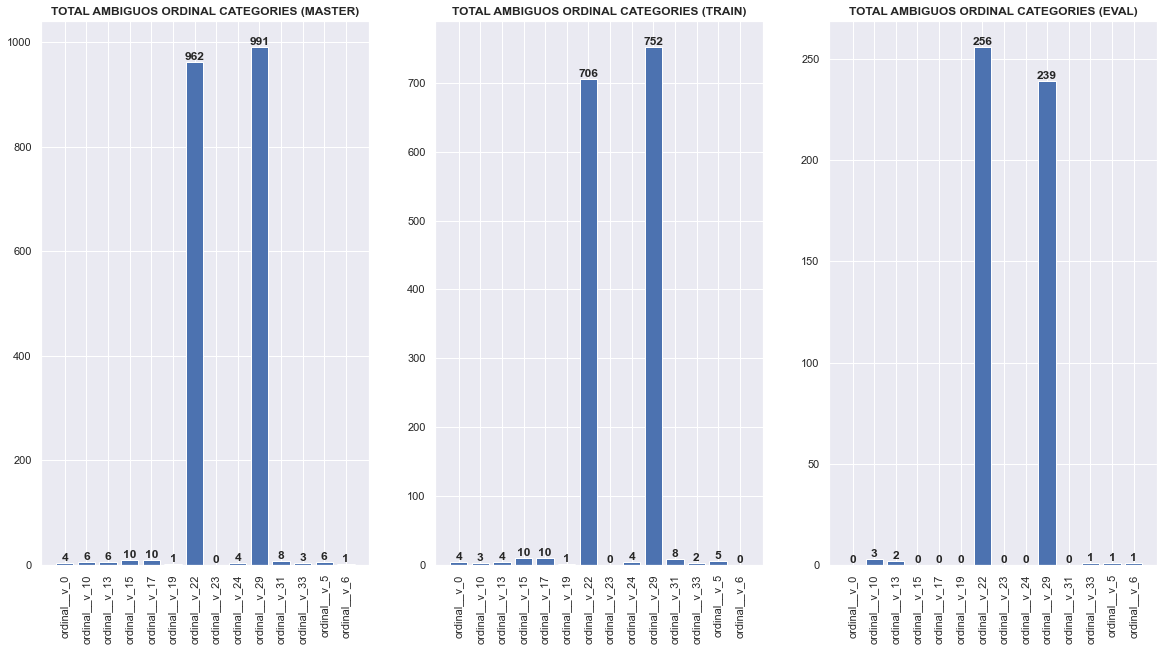

In [124]:
data_to_plot = [
    total_ambiguos_labels_master,
    total_ambiguos_labels_train,
    total_ambiguos_labels_eval
]
data_titles = [
    "Total Ambiguos Ordinal Categories (Master)",
    "Total Ambiguos Ordinal Categories (Train)",
    "Total Ambiguos Ordinal Categories (Eval)",
]
fig, ax = plt.subplots(1,3,squeeze=False,figsize=(20,10))

for idx in range(3):
    # ax_ = ax[idx]
    data = data_to_plot[idx]
    disp = ax[0,idx].bar(data.keys(), height=data.values())
    disp1 = ax[0,idx].set_xticklabels(data.keys(), rotation=90)
    disp = ax[0,idx].bar_label(container=disp,fontweight='bold')
    disp2 = ax[0,idx].set_title(data_titles[idx].upper(), fontweight='bold')
    

###    Load Data Prepared Data

In [ ]:
import pandas as pd


class DFCollection:
    """
    Contains all the data used.
    Upon Init all data gets loaded.
    Save method is also provided.
    """

    def __init__(self):
        self.c_sel = ColumnSelectors()

        self.file_path = "/kaggle/working/"
        if KAGGLE_ENV == 0:
            self.file_path = '../data'+ self.file_path
        self.data = pd.read_parquet(
            self.file_path + "train.parquet"
        )
        self.prediction_data = pd.read_parquet(
            self.file_path + "test.parquet"
        )
        self.data_logits = pd.read_parquet(
            self.file_path + "data_with_ridit.hdfs"
        )
        self.final_data = pd.read_parquet(
            self.file_path + "final_data.parquet"
        )
        self.final_pred_data = pd.read_parquet(
            self.file_path + "final_pred_data.parquet"
        )
        
        self.core_frames = [
            self.data,
            self.prediction_data,
            self.data_logits,
            self.final_data,

        ]
        save_paths = [
            "train.parquet",
            "test.parquet",
            "data_with_ridit.hdfs",
            "final_data.parquet",
            "final_pred_data.parquet",
        ]
        self.save_paths = [self.file_path + x for x in save_paths]
        self.core_names = [x.split(".")[0] for x in self.save_paths]
        self.final_data.rename(columns={"label": "target"}, inplace=True)
        self.data.rename(columns={"label": "target"}, inplace=True)
        self.nominal_categories = {}
        for nc in self.c_sel.nominal_cols:
            ncs = self.master.loc[:, nc].unique()
            self.nominal_categories[nc] = ncs

        self.ordinal_categories = {}
        for nc in self.c_sel.ordinal_cols:
            ncs = self.master.loc[:, nc].unique()
            self.ordinal_categories[nc] = ncs

    @staticmethod
    def __save__(df: pd.DataFrame, loc: str):
        try:
            df.to_parquet(loc)
        except:
            return "Save Failed"
        return "Saved Successfully"

    def save_all(self):
        """
        Before Saving all objects ask question for each of them.
        And for each question if the answer is yes proceed to save otherwise continue.
        """
        exit_msg = "Exiting!"
        try:
            for df_name, df, df_loc in zip(
                self.core_names, self.core_frames, self.save_paths
            ):
                base_question = f"Do you want to save {df_name}?(Yes/No/Exit)"
                skip_msg = f"Skipping {df_name}"
                while True:
                    answer = input(base_question)
                    if answer == "Yes":
                        msg = self.__save__(df, df_loc)
                        print(df_name + msg)
                        break
                    elif answer in ["No", "n"]:
                        print(skip_msg)
                        break
                    elif answer in ["Exit", "e"]:
                        print(exit_msg)
                        return
                    else:
                        print("Not Valid Input")
                        continue
        except KeyboardInterrupt:
            print(exit_msg)
            return

    def categorise_data(self, df: pd.DataFrame = None):

        if isinstance(df, pd.DataFrame):
            ordinal_data = df.loc[:, self.c_sel.ordinal_cols]
            nominal_data = df.loc[:, self.c_sel.nominal_cols]
            binary_data = df.loc[:, self.c_sel.binary_cols]
            ratio_data = df.loc[:, self.c_sel.ratio_cols]
        else:
            df = self.final_data
            ordinal_data = df.loc[:, self.c_sel.ordinal_cols]
            nominal_data = df.loc[:, self.c_sel.nominal_cols]
            binary_data = df.loc[:, self.c_sel.binary_cols]
            ratio_data = df.loc[:, self.c_sel.ratio_cols]
        return ordinal_data, nominal_data, binary_data, ratio_data


# if __name__ == "__main__":
#     db = DFCollection()
